# Building a fully convolutional network (FCN) in TensorFlow
### -> a CNN with variable input dimensions

## 1. Loading and inspecting the Dataset

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time

DS_LENGTH = 27558
TRAIN_LEN = int(DS_LENGTH*0.8)
BUFFER_SIZE = 1024

ds = tfds.load('malaria', 
               split='train', 
               as_supervised=True, 
               shuffle_files=False)

train_ds = ds.take(TRAIN_LEN).shuffle(BUFFER_SIZE)
val_ds = ds.skip(TRAIN_LEN).shuffle(BUFFER_SIZE)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


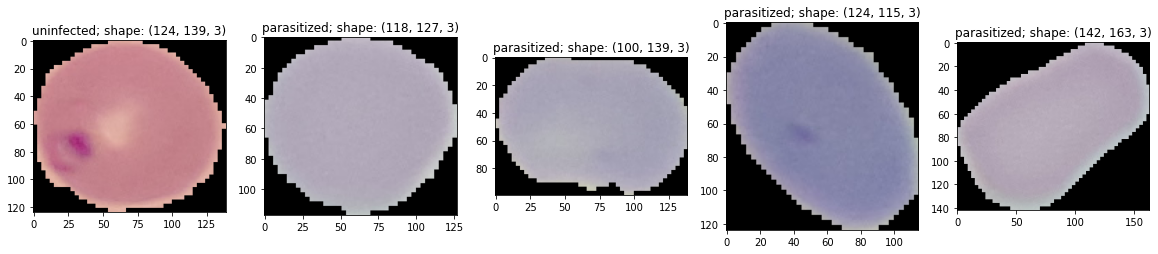

In [2]:
num_plots = 5
fig, axes = plt.subplots(nrows=1, ncols=num_plots, figsize=(20,4))

for i, (img, label) in enumerate(train_ds.take(5)):
    label = 'uninfected' if label == 0 else 'parasitized'
    axes[i].imshow(img)
    axes[i].set_title(f'{label}; shape: {img.shape}')

## 2. Preprocessing the dataset
- one hot encoding of labels
- standardization of images

img: <dtype: 'float32'>, label: <dtype: 'float32'>


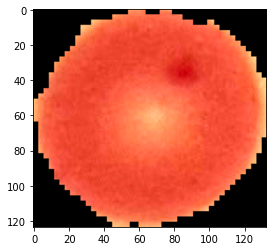

In [3]:
BATCH_SIZE = 1 # due to tf.Dataset calc optimizations all batches need same size 

# Standardizing the images and one hot encoding of the labels
train_ds = train_ds.map(lambda img, label: (tf.image.per_image_standardization(tf.cast(img, tf.float32)/255), tf.one_hot(label, depth=2)), 
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.map(lambda img, label: (tf.image.per_image_standardization(tf.cast(img, tf.float32)/255), tf.one_hot(label, depth=2)),
                    num_parallel_calls=tf.data.experimental.AUTOTUNE)

# for visualization purpose
for img, label in train_ds.take(1):
    print(f'img: {img.dtype}, label: {label.dtype}')
    plt.imshow(img)

# optimizing the datasets for the tensorflow pipeline
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

## 3. The Model

In [4]:
class FCN_model(tf.keras.Model):
    """This Model serves to generate a fully convolutional network, that doesn't need reshaping
    of the images to be feeded into the network.

    Args:
        dropoutRate: int()
                    The amount of dropout passed to Droput layers.
        convFilter: int()
                   The amount of Kernels learned in the initial convolution block. Decreases by a factor of
                   2 throughout proceeding convolution blocks of the network.

    Returns:
        The FCN_model.
    """
    
    def __init__(self, dropoutRate=0.10, convFilter=64):
        super(FCN_model, self).__init__()
        
        self._inputShape = (None, None, None, 3) # batchSample, row, col, channel
        
        # first conv block
        self.conv_0 = tf.keras.layers.Conv2D(filters=convFilter, 
                                             kernel_size=3, 
                                             strides=1,
                                             padding='same',
                                             activation='relu')
        self.conv_01 = tf.keras.layers.Conv2D(filters=convFilter, 
                                             kernel_size=3, 
                                             strides=1,
                                             padding='same',
                                             activation='relu')

        self.drop_0 = tf.keras.layers.Dropout(dropoutRate)
        #self.batch_0 = tf.keras.layers.BatchNormalization()
        self.maxPol_0 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        
        convFilter = convFilter/2
        
        # second conv block
        self.conv_1 = tf.keras.layers.Conv2D(filters=convFilter, 
                                             kernel_size=3, 
                                             strides=1,
                                             padding='same',
                                             activation='relu')
        
        self.conv_11 = tf.keras.layers.Conv2D(filters=convFilter, 
                                             kernel_size=3, 
                                             strides=1,
                                             padding='same',
                                             activation='relu')
        
        self.drop_1 = tf.keras.layers.Dropout(dropoutRate)
        #self.batch_1 = tf.keras.layers.BatchNormalization()
        self.maxPol_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        
        # outpu layer
        self.conv_out = tf.keras.layers.Conv2D(filters=2, 
                                               kernel_size=3, 
                                               strides=1,
                                               padding='valid',
                                               activation='relu')
        self.drop_out = tf.keras.layers.Dropout(dropoutRate)
        self.globalPool_out = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(2, activation='softmax')
        
        self.build(self._inputShape)        
        self.summary()
        
    def call(self, inputs):
        x = self.conv_0(inputs)
        x = self.conv_01(x)
        x = self.drop_0(x)
        x = self.maxPol_0(x)
        x = self.conv_1(x)
        x = self.conv_11(x)
        x = self.drop_1(x)
        x = self.maxPol_1(x)
        x = self.conv_out(x)
        x = self.drop_out(x)
        x = self.globalPool_out(x)
        output = self.classifier(x)
        
        return output


## 4. Training and evaluation of the Model based on the Malaria dataset

In [5]:
class Timer:
    def __init__(self):
        self._start_time = None

    def start(self):
        """Start a new timer"""
        if self._start_time is not None:
            raise TimerError(f"Timer is running. Use .stop() to stop it")

        self._start_time = time.perf_counter()

    def stop(self):
        """Stop the timer, and report the elapsed time"""
        if self._start_time is None:
            print(f"Timer is not running. Use .start() to start it")
            return 0
    
        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        return elapsed_time

@tf.function
def train_step(model, train_ds, loss_function, optimizer, train_loss_metric, train_acc_metric):
    for img, target in train_ds:       
        # forward pass with GradientTape
        with tf.GradientTape() as tape:
            prediction = model(img)
            loss = loss_function(target, prediction)

        # backward pass via GradienTape (auto-gradient calc)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # calculate metrics
        train_loss_metric.update_state(loss)
        train_acc_metric.update_state(target, prediction)

@tf.function
def eval_step(model, ds, loss_function, loss_metric, acc_metric):
    for img, target in ds:
        prediction = model(img)
        loss = loss_function(target, prediction)
        loss_metric.update_state(loss)
        acc_metric.update_state(target, prediction)

In [6]:
# Hyperparameter
EPOCHS = 10
LEARNING_RATE = 1e-4
timer = Timer()

tf.keras.backend.clear_session()

# Initialize the model.
model = FCN_model()
loss_function = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Prepare metrics
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
val_acc_metric = tf.keras.metrics.CategoricalAccuracy()
train_loss_metric = tf.keras.metrics.Mean()
val_loss_metric = tf.keras.metrics.Mean()

# Initialize lists for later visualization.
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
times = []

print(f'[INFO] - Evaluating the Dataset on the {model.name} before training.')
timer.start()

# on train_ds
eval_step(model, train_ds, loss_function, 
          loss_metric=train_loss_metric, 
          acc_metric=train_acc_metric)
train_loss = train_loss_metric.result()
train_acc = train_acc_metric.result()
print(f'train_loss: {train_loss:0.4f}, train_acc: {train_acc:0.4f}')
train_losses.append(train_loss)
train_accuracies.append(train_acc)

# on eval_ds
eval_step(model, val_ds, loss_function, 
          loss_metric=val_loss_metric, 
          acc_metric=val_acc_metric)
val_loss = val_loss_metric.result()
val_acc = val_acc_metric.result()
print(f'val_loss: {val_loss:0.4f}, val_acc: {val_acc:0.4f}') 
val_losses.append(val_loss)
val_accuracies.append(val_acc)

elapsed_time = timer.stop()
times.append(elapsed_time)

print(f'[INFO] - Initialized {model.name} training')
for epoch in range(EPOCHS):
    print(f'[EPOCH] __{epoch}__')
    timer.start()
    
    train_step(model, train_ds, loss_function, optimizer, train_loss_metric, train_acc_metric)
    
    elapsed_time = timer.stop()
    times.append(elapsed_time)
    
    # Evaluating training metrics
    print(f'[INFO] - Finished Epoch __{epoch}__ in {elapsed_time:0.2f} seconds.')
    train_loss = train_loss_metric.result()
    train_acc = train_acc_metric.result()
    print(f'train_loss: {train_loss:0.4f}, train_acc: {train_acc:0.4f}')
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Evaluation model
    timer.start()
    
    eval_step(model, val_ds, loss_function, 
              loss_metric=val_loss_metric, 
              acc_metric=val_acc_metric)
    
    elapsed_time = timer.stop()
    times.append(elapsed_time)
    
    # Evaluating validation metrics
    print(f'[INFO] - Finished evaluation of the {model.name}.')
    val_loss = val_loss_metric.result()
    val_acc = val_acc_metric.result()
    print(f'val_loss: {val_loss:0.4f}, val_accurac: {val_acc:0.4f}') 
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Resetting metrics
    train_acc_metric.reset_states()
    val_acc_metric.reset_states()
    train_loss_metric.reset_states()
    val_loss_metric.reset_states()
    
    print(f'[INFO] - Full time elapsed: {np.sum(times)/60:0.4f} min.')

Model: "fcn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  1792      
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  36928     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  18464     
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  9248      
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0 

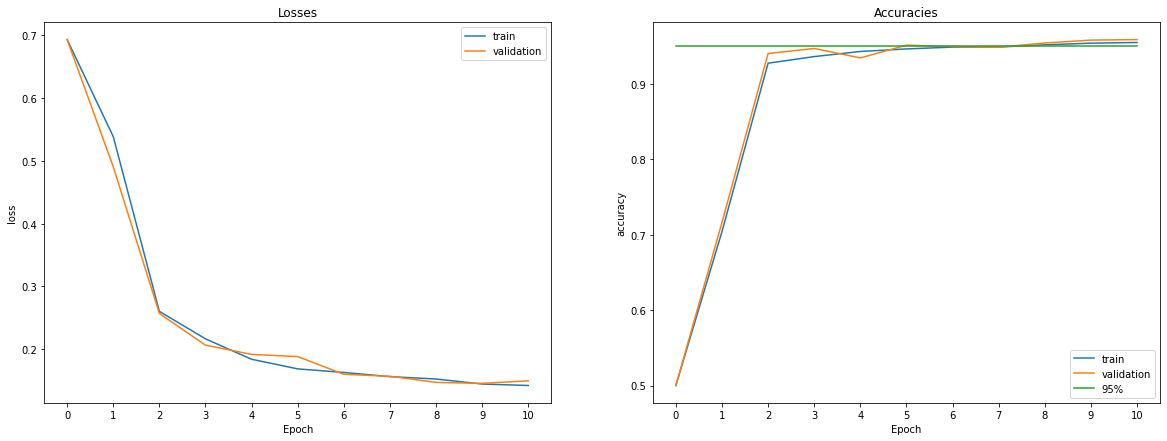

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

x = np.arange(len(train_losses))

# losses
axes[0].plot(x, train_losses, label='train')
axes[0].plot(x, val_losses, label='validation')
axes[0].legend()
axes[0].set(title='Losses', xlabel='Epoch', ylabel='loss', xticks=x)

# accuracies
axes[1].plot(x, train_accuracies, label='train')
axes[1].plot(x, val_accuracies, label='validation')
axes[1].plot([0.95 for _ in range(len(val_accuracies))], label='95%')
axes[1].legend()
axes[1].set(title='Accuracies', xlabel='Epoch', ylabel='accuracy', xticks=x)

plt.show()